### Imports

In [1]:
# general
import pandas as pd
import numpy as np
import re
import plotnine as p9

# twitter scraping
import snscrape.modules.twitter as sntwitter

# roBERTa
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from scipy.special import softmax
import torch

# nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# stats
from statsmodels.stats.proportion import proportions_ztest

### Twitter scraping

In [2]:
query = '"prop 30"  until:2022-11-08 since:2022-07-01'
tweets = []
limit = 5000

In [3]:
for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    if len(tweets) == limit:
        break
    tweet_data = [tweet.date, tweet.user.username, tweet.content, tweet.likeCount, tweet.retweetCount]
    tweets.append(tweet_data)

In [4]:
tweets_df = pd.DataFrame(tweets, columns = ['Date', 'User', 'Content', 'Likes', 'Retweets'])

In [5]:
tweets_df

,Date,User,Content,Likes,Retweets
0,2022-11-07 23:01:03+00:00,YousefBaig,"Newsom claimed Prop. 30 ""puts corporate welfar...",1,4
1,2022-11-07 22:59:20+00:00,ClimateResolve,#Prop30 is pivotal to help our state combat da...,5,6
2,2022-11-07 22:56:18+00:00,trader_mtg,@ecommerceshares Wait until Prop 30 gets shot ...,1,0
3,2022-11-07 22:47:35+00:00,LByock,@dhere I voted no on 27 (which is in conflict ...,1,1
4,2022-11-07 22:39:45+00:00,SFBayPSR,"VOTE YES on Prop 30! If we don’t act, Californ...",10,7
...,...,...,...,...,...
2673,2022-07-02 01:01:34+00:00,alfred_twu,Prop 30: Electric Vehicles &amp; Wildfire Prev...,23,3
2674,2022-07-01 22:57:49+00:00,wickedmitch_,Tentative votes:\nProp 1: yes\nProp 26: yes\nP...,0,0
2675,2022-07-01 21:49:09+00:00,davidaguilar92,California's Secretary of State just released ...,0,0
2676,2022-07-01 20:22:45+00:00,RL_Miller,"Prop 1: OH HELL YES\nProp 26: Maybe, but not w...",1,0


### Data Preprocessing Function

In [7]:
def preprocess(text: str) -> str:
    '''
    Performs basic preprocessing on text to meet specifications of roBERTa model.
    References to other users ('@user123') will be replaced with '@user'.
    Any links ('https://www.google.com/') will be replaced with 'http'
    '''
    elements = []
    for element in text.split(' '):
        if element.startswith('@') and len(element) > 1:
            element = '@user'
        elif element.startswith('http'):
            element = 'hhtp'
        elements.append(element)
    return ' '.join(elements)

### Load in NLTK's [VADER](https://www.nltk.org/_modules/nltk/sentiment/vader.html) sentiment analyzer

In [8]:
nltk_sia = SentimentIntensityAnalyzer()

### Load in [RoBERTa](https://huggingface.co/docs/transformers/model_doc/roberta) model from [Hugging Face](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest?text=Covid+cases+are+increasing+fast%21)

In [9]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Perform sentiment analysis with VADER and RoBERTa

In [10]:
def roberta(text: str):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    labels = config.id2label.values()
    scores_dict = dict(zip(labels, scores))
    
    scores_dict['Method'] = 'R'
    return scores_dict

In [11]:
def vader(text: str):
    text = preprocess(text)
    scores = nltk_sia.polarity_scores(text)
    scores.pop('compound')
    scores = list(scores.values())

    key_names = ['Negative', 'Neutral', 'Positive']
    scores_dict = dict(zip(key_names, scores))
    scores_dict['Method'] = 'V'
    return scores_dict

In [12]:
def get_sentiment(scores):
    method = scores.pop('Method')
    sentiment = max(scores, key = scores.get)
    scores['Method'] = method
    return sentiment

In [13]:
def sentiment_analysis(text:str, method:str):
    '''
    First checks if tweet contains various phrases that result in a trivial sentiment determination.
    Otherwise, performs roBERTa sentiment analysis.
    Returns a dictionary containing the probabilities of each sentiment and the sentiment with the greatest probability.
    For our analysis, Yes = 'Positive' and No = 'Negative'.
    '''
    
    positive_regex = 'yeson.{0,5}(prop)?.?30|prop.?30.?yes'
    negative_regex = 'noon.{0,5}(prop)?.?30|prop.?30.?no'

    lower_text = text.lower()
    # contains positive phrases
    if bool(re.search(positive_regex, lower_text.replace(' ',''))):
        sentiment_scores = {'Negative': 0, 'Neutral': 0, 'Positive': 1, 'Sentiment': 'Positive', 'Method': method}
    # contains negative phrases
    elif bool(re.search(negative_regex, lower_text.lower().replace(' ',''))):
        sentiment_scores = {'Negative': 1, 'Neutral': 0, 'Positive': 0, 'Sentiment': 'Negative', 'Method': method}
    else:
        if method == 'R':
            sentiment_scores = roberta(text)

        elif method == 'V':
            sentiment_scores = vader(text)
        else:
            return f'unknown model: {method}'
          
        sentiment = get_sentiment(sentiment_scores)
        sentiment_scores['Sentiment'] = sentiment
    
    return sentiment_scores

#### Run sentiment analysis on all tweets

In [14]:
results = []
for index, row in tweets_df.iterrows():
    sentiment_scores_roberta = sentiment_analysis(row['Content'], 'R')
    sentiment_scores_vader = sentiment_analysis(row['Content'], 'V')
    results.append(sentiment_scores_roberta)
    results.append(sentiment_scores_vader)
sentiment_df = pd.DataFrame(results)
sentiment_df

,Negative,Neutral,Positive,Method,Sentiment
0,0.699022,0.268416,0.032562,R,Negative
1,0.000000,0.951000,0.049000,V,Neutral
2,0.000000,0.000000,1.000000,R,Positive
3,0.000000,0.000000,1.000000,V,Positive
4,0.767167,0.220800,0.012033,R,Negative
...,...,...,...,...,...
5351,0.000000,1.000000,0.000000,V,Neutral
5352,0.143333,0.739530,0.117137,R,Neutral
5353,0.131000,0.668000,0.201000,V,Neutral
5354,0.026903,0.892237,0.080860,R,Neutral


#### Merge tweets_df and sentiment_df

In [15]:
tweets_df_double = pd.DataFrame(np.repeat(tweets_df.values, 2, axis = 0), columns = tweets_df.columns)

In [16]:
sa_df = pd.concat([tweets_df_double, sentiment_df], axis=1)
sa_df

,Date,User,Content,Likes,Retweets,Negative,Neutral,Positive,Method,Sentiment
0,2022-11-07 23:01:03+00:00,YousefBaig,"Newsom claimed Prop. 30 ""puts corporate welfar...",1,4,0.699022,0.268416,0.032562,R,Negative
1,2022-11-07 23:01:03+00:00,YousefBaig,"Newsom claimed Prop. 30 ""puts corporate welfar...",1,4,0.000000,0.951000,0.049000,V,Neutral
2,2022-11-07 22:59:20+00:00,ClimateResolve,#Prop30 is pivotal to help our state combat da...,5,6,0.000000,0.000000,1.000000,R,Positive
3,2022-11-07 22:59:20+00:00,ClimateResolve,#Prop30 is pivotal to help our state combat da...,5,6,0.000000,0.000000,1.000000,V,Positive
4,2022-11-07 22:56:18+00:00,trader_mtg,@ecommerceshares Wait until Prop 30 gets shot ...,1,0,0.767167,0.220800,0.012033,R,Negative
...,...,...,...,...,...,...,...,...,...,...
5351,2022-07-01 21:49:09+00:00,davidaguilar92,California's Secretary of State just released ...,0,0,0.000000,1.000000,0.000000,V,Neutral
5352,2022-07-01 20:22:45+00:00,RL_Miller,"Prop 1: OH HELL YES\nProp 26: Maybe, but not w...",1,0,0.143333,0.739530,0.117137,R,Neutral
5353,2022-07-01 20:22:45+00:00,RL_Miller,"Prop 1: OH HELL YES\nProp 26: Maybe, but not w...",1,0,0.131000,0.668000,0.201000,V,Neutral
5354,2022-07-01 19:50:46+00:00,JeremyBWhite,NEW: Ballot numbers!\n\nPROP 1: Enshrine abort...,148,71,0.026903,0.892237,0.080860,R,Neutral


### Plots

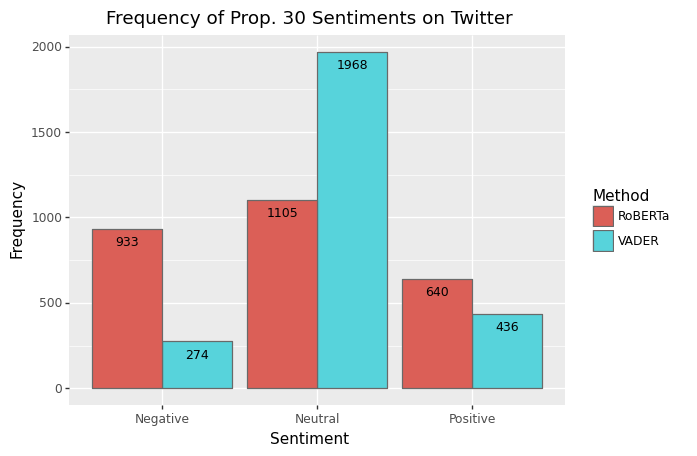

<ggplot: (138022456233)>

In [17]:
(
    p9.ggplot(data = sa_df, mapping = p9.aes(x = 'Sentiment', fill = 'Method'))
    + p9.geom_bar(color = 'dimgray', position = 'dodge')
    +p9.labs(title = 'Frequency of Prop. 30 Sentiments on Twitter', y = 'Frequency')
    + p9.scale_fill_discrete(labels = ['RoBERTa', 'VADER'])
    + p9.geom_text(p9.aes(label = p9.after_stat('count'), y = p9.stage(after_stat='count', after_scale='count - 75')), stat = 'count',position= p9.position_dodge2(width = 0.9), size = 9)
)

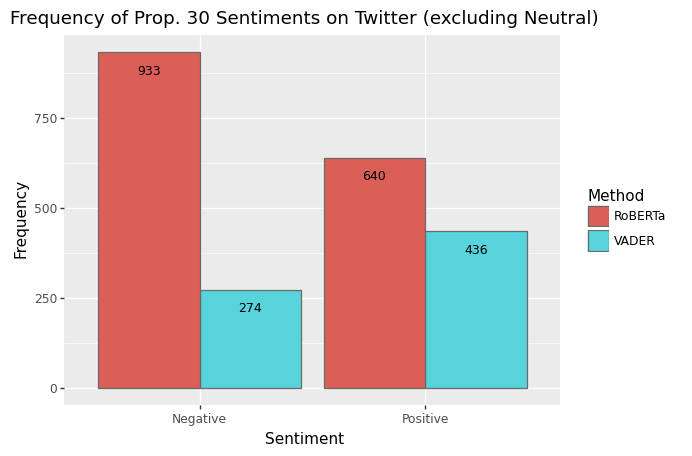

<ggplot: (138022753710)>

In [18]:
(
    p9.ggplot(data = sa_df[sa_df['Sentiment'] != 'Neutral'], mapping = p9.aes(x = 'Sentiment', fill = 'Method'))
    + p9.geom_bar(color = 'dimgray', position = 'dodge')
    + p9.labs(title = 'Frequency of Prop. 30 Sentiments on Twitter (excluding Neutral)', y = 'Frequency')
    + p9.scale_fill_discrete(labels = ['RoBERTa', 'VADER'])
    + p9.geom_text(p9.aes(label = p9.after_stat('count'), y = p9.stage(after_stat='count', after_scale='count - 50')), stat = 'count',position= p9.position_dodge2(width = 0.9), size = 9)
)

In [19]:
counts_df = sa_df[sa_df['Sentiment'] != 'Neutral'].groupby('Method')['Sentiment'].value_counts().to_frame()
counts_df.rename(columns = {'Sentiment': 'Count'}, inplace=True)
counts_df.reset_index(inplace=True)
total_counts = counts_df.groupby('Method')['Count'].sum().to_list()
total_counts = np.repeat(total_counts, 2)
counts_df['Percentage'] = counts_df['Count'] / total_counts
counts_df['graph_pos'] = counts_df['Percentage'] / 2

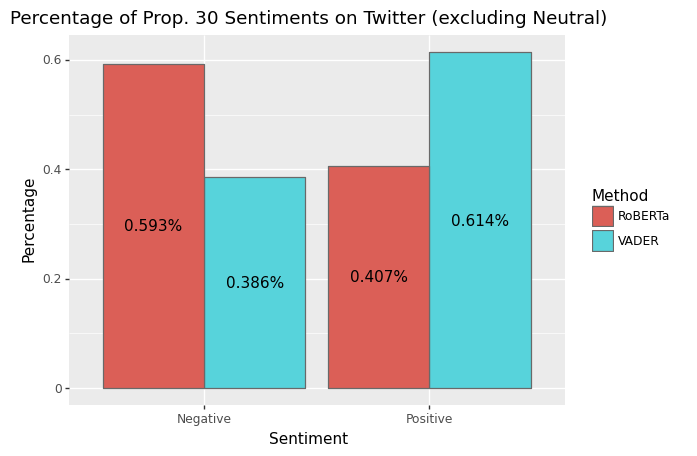

<ggplot: (138022456053)>

In [20]:
(
    p9.ggplot(data = counts_df, mapping = p9.aes(x = 'Sentiment', y = 'Percentage',fill = 'Method'))
    + p9.geom_bar(stat = 'identity', color = 'dimgray',position = 'dodge')
    + p9.labs(title = 'Percentage of Prop. 30 Sentiments on Twitter (excluding Neutral)', y = 'Percentage')
    + p9.scale_fill_discrete(labels = ['RoBERTa', 'VADER'])
    + p9.geom_text(p9.aes(label = 'Percentage', y = 'graph_pos'), position = p9.position_dodge2(width=0.9), format_string='{:.3f}%', size = 11)
)

### Hypothesis testing

We wil be comparing the proportion of positive/negative _sentiments_ ($P_S$) and the proportion of Yes/No votes on the _real_ ballot ($P_R$) by performing a **two-proportion z-test**.

Our null hypothesis is that the two proportion have a difference of $0$: $H_0:$ $P_S - P_R = 0$.

Our alternative hypothesis is that the two proportions are different: $H_A:$ $P_S - P_R \ne 0$.

We will be using a significance level of $\alpha = 0.05$.

In [42]:
def HTest_Response(pvalue, alpha):
    if pvalue <= alpha:
        return f'{pvalue} is less than or equal to {alpha}, therefore reject the null hypothesis.'
    else:
        return f'{pvalue} is greater than {alpha}, therefore fail to reject the null hypothesis.'

In [41]:
alpha = 0.05
counts_df

,Method,Sentiment,Count,Percentage,graph_pos
0,R,Negative,933,0.593134,0.296567
1,R,Positive,640,0.406866,0.203433
2,V,Positive,436,0.614085,0.307042
3,V,Negative,274,0.385915,0.192958


##### Twitter counts and sample sizes

In [33]:
r_negative_count, r_positive_count = counts_df[(counts_df['Method'] == 'R')]['Count'].to_list()
v_negative_count, v_positive_count = counts_df[(counts_df['Method'] == 'V')]['Count'].to_list()
r_sample = r_negative_count + r_positive_count
v_sample = v_negative_count + v_positive_count

##### Poll counts and sample size

In [36]:
poll_negative_count = 5_953_218
poll_positive_count = 4_365_003
poll_sample = poll_negative_count + poll_positive_count

**RoBERTa**

In [43]:
# comparing Negative and No
z_stat_r_neg, p_value_r_neg = proportions_ztest(count = [r_negative_count, poll_negative_count], nobs = [r_sample, poll_sample], value = 0.0, alternative= 'two-sided')
HTest_Response(p_value_r_neg, alpha)

'0.19421551764494482 is greater than 0.05, therefore fail to reject the null hypothesis.'

In [44]:
# comparing Positive and Yes
z_stat_r_pos, p_value_r_pos = proportions_ztest(count = [r_positive_count, poll_positive_count], nobs = [r_sample, poll_sample], value = 0.0, alternative= 'two-sided')
HTest_Response(p_value_r_pos, alpha)

'0.19421551764494338 is greater than 0.05, therefore fail to reject the null hypothesis.'

**VADER**

In [45]:
# comparing Negative and No
z_stat_v_neg, p_value_v_neg = proportions_ztest(count = [v_negative_count, poll_negative_count], nobs = [v_sample, poll_sample], value = 0.0, alternative= 'two-sided')
HTest_Response(p_value_v_neg, alpha)

'0.04527067748112547 is less than or equal to 0.05, therefore reject the null hypothesis.'

In [46]:
# comparing Positive and Yes
z_stat_v_pos, p_value_v_pos = proportions_ztest(count = [v_positive_count, poll_positive_count], nobs = [v_sample, poll_sample], value = 0.0, alternative= 'two-sided')
HTest_Response(p_value_v_pos, alpha)

'0.04527067748112483 is less than or equal to 0.05, therefore reject the null hypothesis.'